In [1]:
# Alpha_RNNs_weather
# Author: Matthew Dixon
# Version: 1.1 (27.2.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6 and Tensorflow 1.3.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# M.F Dixon, Industrial Forecasting with Exponentially Smoothed Recurrent Neural Networks, preprint, 2020.

In [6]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random

# Imports for alpha_rnns 
from IPython import display
import tensorflow as tf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Layer, LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import Layer,RNN
from keras import backend as K
from keras import layers
import keras.layers
from keras.legacy import interfaces
from keras import *
from alphaRNN import *
from alphatRNN import *
import tensorflow as tf

from numpy.random import seed
from tensorflow import set_random_seed

# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [23]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50, min_delta=1e-7, restore_best_weights=True)

# Data Generation

In [7]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [10]:
use_features = ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)']

In [11]:
target = 'T (degC)'
n_steps = 20 # number of lags to include in the model
train_weight = 0.8

df_new = df[:30000]
df_new[use_features].astype('float32').dtypes
split = int(len(df_new)*train_weight)

df_train = df_new[use_features].iloc[:split] 
df_train[use_features].astype('float32').dtypes
mu = df_train[use_features].mean()
sigma = df_train[use_features].std()
std_df_train = (df_train[use_features] - mu)/sigma
df_train = std_df_train 
df_test = df_new[use_features].loc[split:]
std_df_test = (df_test[use_features].loc[split:] - mu)/sigma
df_test = std_df_test

## Statistical diagnostics

## Augmented Dickey-Fuller test

In [15]:
for feature in use_features:
    adf, p, usedlag, nobs, cvs,aic=sm.tsa.stattools.adfuller(df_new[feature][:10000])
    print(feature, adf,p, nobs, cvs)

p (mbar) -3.8139805982886608 0.0027674707965053644 9983 {'1%': -3.431005212086098, '5%': -2.861829564712288, '10%': -2.5669241301591046}
T (degC) -4.760996819437093 6.454147170146432e-05 9961 {'1%': -3.4310066595695945, '5%': -2.861830204343065, '10%': -2.5669244706354584}
Tpot (K) -4.404673004589229 0.0002912309335644808 9961 {'1%': -3.4310066595695945, '5%': -2.861830204343065, '10%': -2.5669244706354584}
Tdew (degC) -4.170958682611065 0.0007375862034841664 9966 {'1%': -3.431006330034765, '5%': -2.861830058724424, '10%': -2.566924393122448}
rh (%) -11.234314284361963 1.8737483678258257e-20 9984 {'1%': -3.431005146443003, '5%': -2.8618295357051493, '10%': -2.5669241147185655}
VPmax (mbar) -5.346549344218809 4.3822434707943234e-06 9962 {'1%': -3.4310065936361585, '5%': -2.861830175207641, '10%': -2.5669244551266304}
VPact (mbar) -4.194144540593466 0.0006741005691156316 9983 {'1%': -3.431005212086098, '5%': -2.861829564712288, '10%': -2.5669241301591046}
VPdef (mbar) -11.283382891699855

Text(0,0.5,'$\\tau_j$')

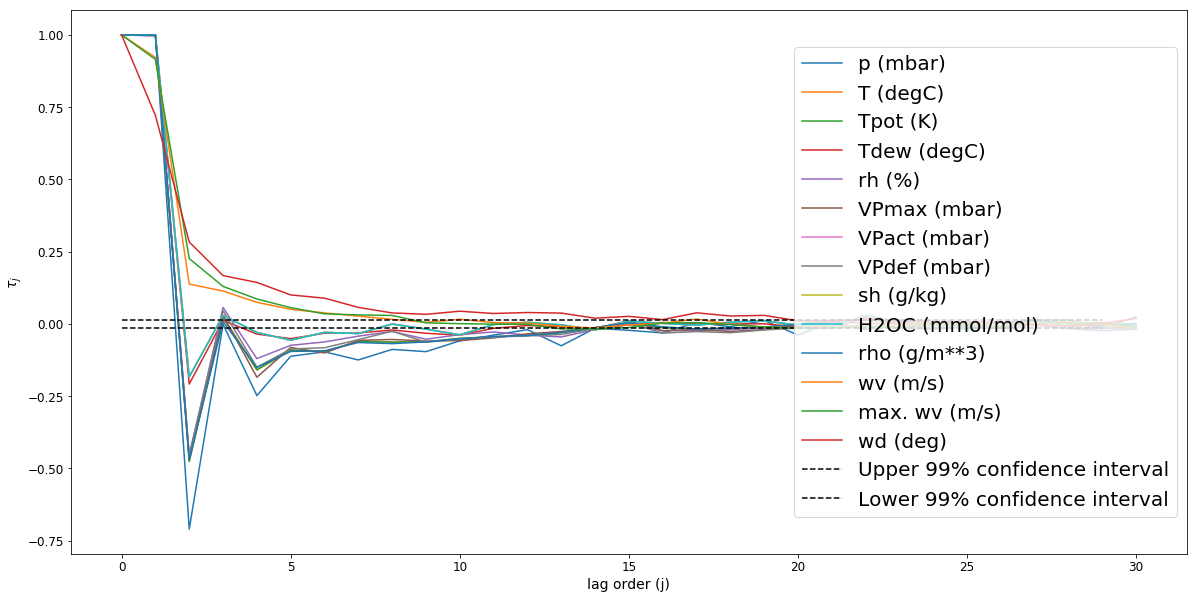

In [16]:
plt.figure(figsize=(20,10))
for feature in use_features:
    pacf=sm.tsa.stattools.pacf(df_new[feature], nlags=30)
    plt.plot(pacf, label=feature)
plt.plot([2.58/np.sqrt(len(df_new))]*30, label='Upper 99% confidence interval', color='black', linestyle='--')
plt.plot([-2.58/np.sqrt(len(df_new))]*30, label='Lower 99% confidence interval', color='black', linestyle='--')

plt.legend(loc=5,prop={'size': 20})
plt.xlabel('lag order (j)')
plt.ylabel('$\\tau_j$')
#n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(df[use_features])))==False)[0][0] -1

### Data structure manipulation for RNNs

In [24]:
def get_lagged_features(value, n_steps,n_steps_ahead):
    """
    value: feature value to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    for lag in range(n_steps+n_steps_ahead-1, n_steps_ahead-1, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [18]:
n_steps_ahead=10

x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps, n_steps_ahead).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps,n_steps_ahead).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [19]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(23971, 20, 14) (23971, 1, 1) (5971, 20, 14) (5971, 1, 1)


In [20]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]
time_size = y_train_reg.shape[1]

In [21]:
print(train_batch_size)

23971


In [26]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))

In [27]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

### Keras Wrappers

In [28]:
def AlphatRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(AlphatRNN(n_units, activation='tanh', recurrent_activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def AlphaRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True)) 
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [29]:
max_epoches=2000
batch_size=1000

In [30]:
params = {'rnn': {'model':'', 'function':SimpleRNN_, 'l1_reg':0.0, 'H':10, 'color': 'blue', 'label':'RNN'}, 
          'alpharnn': {'model':'', 'function':AlphaRNN_,'l1_reg':0.001, 'H':5,'color': 'green', 'label': '$\\alpha$-RNN' }, 
          'alphatrnn': {'model':'', 'function':AlphatRNN_,'l1_reg':0.0, 'H':5, 'color': 'cyan', 'label': '$\\alpha_t$-RNN'},
          'gru': {'model':'', 'function':GRU_,'l1_reg':0.001, 'H':10, 'color': 'orange', 'label': 'GRU'},
          'lstm': {'model':'', 'function':LSTM_,'l1_reg':0.0, 'H':5, 'color':'red', 'label': 'LSTM'}
         }

# Cross-validation

In [34]:
cross_val=False # Warning: Changing this to True will take several hours to run
if cross_val:
    n_units = [5,10,20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    tscv = TimeSeriesSplit(n_splits = 5)
    param_grid = dict(n_units=n_units,l1_reg=l1_reg)

    for key in params.keys(): # params[key]['function']
        model = KerasRegressor(build_fn=params[key]['function'], epochs=max_epoches, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

    params[key]['H'] = grid_result.best_params_['n_units']
    params[key]['l1_reg']= grid_result.best_params_['l1_reg']

# Train cross-validated model

In [ ]:
for key in params.keys():
    set_random_seed(0)
    model=params[key]['function'](params[key]['H'],params[key]['l1_reg'])
    model.fit(x_train_reg,y_train_reg,epochs=max_epoches, batch_size=batch_size,callbacks=[es],shuffle=False)
    params[key]['model']=model

Epoch 1/2000
23971/23971 [==============================] - 1s 51us/step - loss: 1.6501
Epoch 2/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.9138
Epoch 3/2000
23971/23971 [==============================] - 0s 11us/step - loss: 0.5909
Epoch 4/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.4535
Epoch 5/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.3816
Epoch 6/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.3316
Epoch 7/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.2927
Epoch 8/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.2613
Epoch 9/2000
23971/23971 [==============================] - 0s 11us/step - loss: 0.2355
Epoch 10/2000
23971/23971 [==============================] - 0s 12us/step - loss: 0.2144
Epoch 11/2000
23971/23971 [==============================] - 0s 13us/step - loss: 0.1971
Epoch 12/2000
23971/23971 [===

23971/23971 [==============================] - 0s 9us/step - loss: 0.0284
Epoch 185/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0283
Epoch 186/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0283
Epoch 187/2000
23971/23971 [==============================] - 0s 11us/step - loss: 0.0283
Epoch 188/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.0283
Epoch 189/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0283
Epoch 190/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0282
Epoch 191/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0282
Epoch 192/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0282
Epoch 193/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0282
Epoch 194/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.0281
Epoch 195/2000
23971/23971 [=====

23971/23971 [==============================] - 0s 9us/step - loss: 0.0258
Epoch 367/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0258
Epoch 368/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.0258
Epoch 369/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0257
Epoch 370/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0257
Epoch 371/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0257
Epoch 372/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0257
Epoch 373/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0257
Epoch 374/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0257
Epoch 375/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0257
Epoch 376/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0257
Epoch 377/2000
23971/23971 [=======

In [ ]:
for key in params.keys():
  model=params[key]['model']
  model.summary()
    
  params[key]['MSE_train']= mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:],model.predict(x_train_reg, verbose=1))
  params[key]['predict'] = model.predict(x_test_reg, verbose=1) 
  params[key]['MSE_test']= mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:],params[key]['predict'])

## Plot predictions

In [ ]:
fig = plt.figure(figsize=(12,7))
upper = 2000
plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], df_test[use_feature][n_steps+n_steps_ahead-1:upper], color="black", label="Observed")

for key in params.keys():
  plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], params[key]['predict'][:upper-(n_steps+n_steps_ahead-1), 0], color=params[key]['color'], label=params[key]['label'])
plt.legend(loc="best", fontsize=12)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.title('Observed vs Model (Testing)', fontsize=16)

plt.show()   

## Plot prediction error

In [ ]:
fig = plt.figure(figsize=(12,7))

for key in params.keys():
  plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], df_test[use_feature][n_steps+n_steps_ahead-1:upper]-params[key]['predict'][:upper-(n_steps+n_steps_ahead-1), 0], color=params[key]['color'], label=params[key]['label'] + " (" +  str(round(params[key]['MSE_test'],3)) +")")

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y-$\hat{Y}$', fontsize=20)

plt.show()